## Problem statement 

Describe your four questions. Articulate your questions using absolutely no jargon. 

Are there unequal distributions of programming based on subject matter? For online programming, what is the distribution of subjects for both one-time events and longer-term programs? For in-person programming, are there unequal distributions of programming amongst communities for certain subjects?

## Data sources
What data did you use? Provide details about your data. Include links to data if you are using open-access data.

https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6

I attempted to find any inequities between program subject matters. I split this task into looking at both online and in-person programs separately. Firstly, I differentiated the online programs by their length using the label 'tag' in the MyChi dataset. I looked at the subject distributions for the one-time events as well as the longer-term programs.

In [81]:
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
my_chi = pd.read_csv('/Users/danielqian/Downloads/My_CHI._My_Future._Programs.csv')
online = my_chi[my_chi['Meeting Type'] == 'online']
online_programs = online[online['Tag'] == 'Program']
online_events = online[online['Tag'] == 'Event']
subject_counts_op = online_programs['Category Name'].value_counts()

Text(0.5, 1.0, 'Online programs by subject')

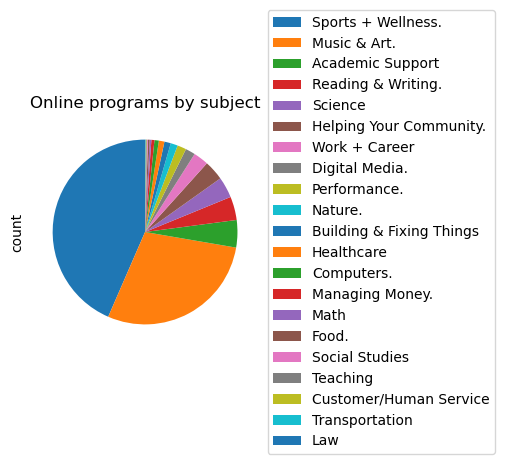

In [94]:
#| echo: false
# online longer-term programs pie chart
subject_counts_op.plot.pie(legend = True, figsize = (4, 3), labels = None, startangle = 90)
plt.legend(subject_counts_op.index, loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.title('Online programs by subject')

As we can see in the figure, 'sports & wellness' and 'music & art' take up a large portion of the online longer-term programs. More programming in academic areas such as 'academic support', 'reading & writing', 'science', 'math', etc. could be beneficial because it would provide more lasting support to students who need tutoring. 

Text(0.5, 1.0, 'Online events by subject')

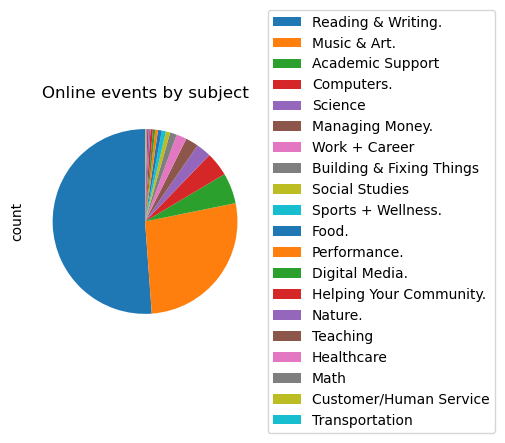

In [100]:
#| echo: false
# online one-time events pie chart
subject_counts_oe.plot.pie(legend = True, figsize = (4, 3), labels = None, startangle = 90)
plt.legend(subject_counts_oe.index, loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.title('Online events by subject')

For the one-time online events, we can see that 'reading & writing' as well as 'music & art' take up a large chunk of the offerings. Adding more diverse programming could benefit communities by providing more opportunities for people to discover new hobbies or interests. For example, offering more computer or digital media events could make people realize they are very interested in coding or filming, photography, etc. and give them a new passion to dive into.

For the in-person programming, I looked for unequal distribution of subjects based on location. To do this, I used a dataset of community boundaries from the Chicago Data Portal in order to assign a community area to each in-person program. This dataset had a "geometry" column that had boundaries for each commmunity in the form of multipolygon complex shapes. First, I used the latitude and longitude columns of the data to turn each program into a point. I then used the geopandas function sjoin to see which community each program fell into. The major issue I anticipated was getting the geographical data of the Chicago Data Portal dataset into a form that was workable with the MyChi data. A problem I encountered was making sure the two datasets were properly aligned so that they could be merged. Eventually I found that the issue was they needed to have the same coordinate reference system. Once that was resolved, I merged the datasets so I could have both the community area as well as the subject of each program. Then, by calculating the square mileage of each community, I was able to find the programs per square mile of each community for different subject matters. Visualizations for a few of the most common subject matters are provided below.

In [ ]:
#| echo: false
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
# preparing the Chicago Data Portal community areas dataset
boundaries = gpd.read_file('/Users/danielqian/Downloads/CommAreas_20241122.csv')
boundaries['the_geom'] = boundaries['the_geom'].apply(wkt.loads)
boundaries_gdf = gpd.GeoDataFrame(boundaries, geometry = 'the_geom')
boundaries_gdf.set_crs('EPSG:4326', inplace = True)
in_person = my_chi[my_chi['Meeting Type'] == 'face_to_face']
in_person_has_coord = in_person.dropna(subset = ['Latitude', 'Longitude'])
coords = in_person_has_coord[['Latitude', 'Longitude']]
coords['geometry'] = coords.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis = 1)
coord_gdf = gpd.GeoDataFrame(coords, geometry = 'geometry')
coord_gdf.set_crs('EPSG:4326', inplace = True)
# joining Chicago Data Portal and MyChi datasets
programs_in_communities = gpd.sjoin(coord_gdf, boundaries_gdf, how = "inner", op = 'within')
programs_with_communities = in_person_has_coord.join(programs_in_communities, lsuffix = '_df', rsuffix = '_gdf')
# dealing with programs with NAn values for the point coordinates
na = programs_with_communities[programs_with_communities['COMMUNITY'].isna()]
na['geometry_left'] = na.apply(lambda row: Point(row['Longitude_df'], row['Latitude_df']), axis = 1)
na_indices = na.index
programs_with_communities.loc[na_indices, 'geometry_left'] = na['geometry_left']
# grouping programs by communities and calculating square mileages
programs_per_area = programs_with_communities.groupby('COMMUNITY').size()
programs_with_communities['SHAPE_AREA'] = pd.to_numeric(programs_with_communities['SHAPE_AREA'])
programs_with_communities['square miles'] = programs_with_communities['SHAPE_AREA'] / 27878400

Text(0.5, 1.0, 'Bottom 15 and top 5 communities in academic support programming per sq mi')

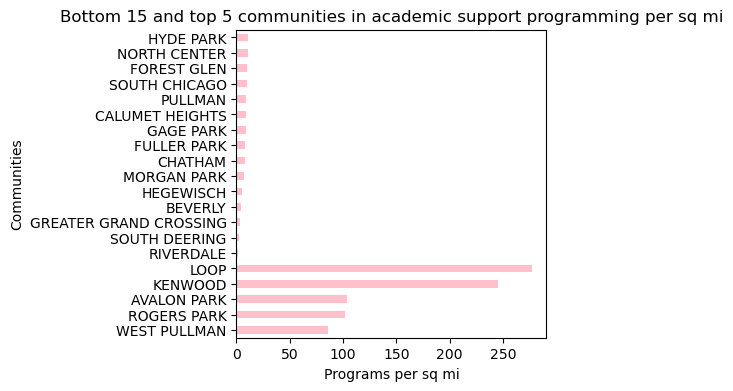

In [102]:
#| echo: false
# academic support programs per square mile bar chart
academic_support = programs_with_communities[programs_with_communities['Category Name'] == 'Academic Support']
support_by_comm = academic_support.groupby('COMMUNITY').size().reset_index(name = 'program_count')
academic_support = academic_support.merge(support_by_comm, on = 'COMMUNITY', how = 'left')
support_per_sq_mi = academic_support['program_count'] / academic_support['square miles']
sorted_per = support_per_sq_mi.drop_duplicates().sort_values()
sorted_per_best_5 = sorted_per[-6:-1]
sorted_per_worst_15 = sorted_per[:15]
best_and_worst = pd.concat([sorted_per_best_5, sorted_per_worst_15])
indices = best_and_worst.index
df_slice = academic_support.iloc[indices]
plt.figure(figsize = (4,4))
comparison_plot = best_and_worst.plot(kind = 'barh', color = 'pink')
comparison_plot.set_yticklabels(df_slice['COMMUNITY'])
plt.ylabel('Communities')
plt.xlabel('Programs per sq mi')
plt.title('Bottom 15 and top 5 communities in academic support programming per sq mi')

Text(0.5, 1.0, 'Bottom 15 and top 5 communities in reading & writing programming per sq mi')

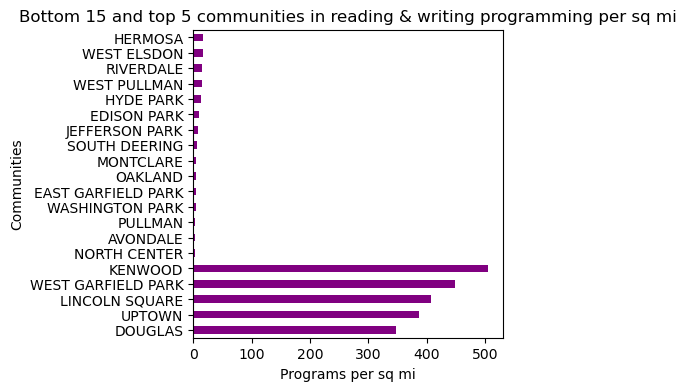

In [103]:
#| echo: false
# reading and writing programs per square mile bar chart
reading = programs_with_communities[programs_with_communities['Category Name'] == 'Reading & Writing.']
reading_by_comm = reading.groupby('COMMUNITY').size().reset_index(name = 'program_count')
reading = reading.merge(reading_by_comm, on = 'COMMUNITY', how = 'left')
reading_per_sq_mi = reading['program_count'] / reading['square miles']
sorted_per_reading = reading_per_sq_mi.drop_duplicates().sort_values()
sorted_per_best_reading = sorted_per_reading[-6:-1]
sorted_per_worst_reading = sorted_per_reading[:15]
best_and_worst_reading = pd.concat([sorted_per_best_reading, sorted_per_worst_reading])
indices_reading = best_and_worst_reading.index
df_slice_reading = reading.iloc[indices_reading]
plt.figure(figsize = (4,4))
comparison_plot_reading = best_and_worst_reading.plot(kind = 'barh', color = 'purple')
comparison_plot_reading.set_yticklabels(df_slice_reading['COMMUNITY'])
plt.ylabel('Communities')
plt.xlabel('Programs per sq mi')
plt.title('Bottom 15 and top 5 communities in reading & writing programming per sq mi')


Text(0.5, 1.0, 'Bottom 15 and top 5 communities in art & music programming per sq mi')

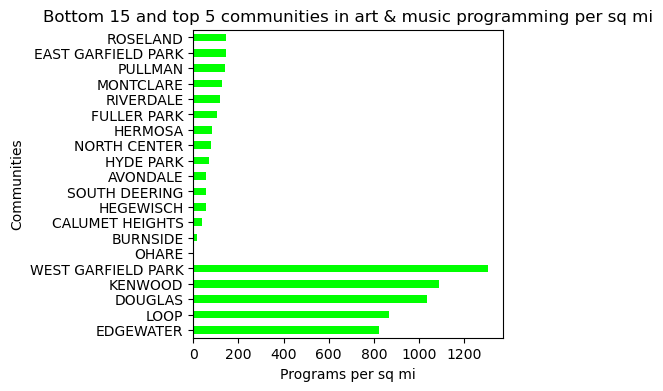

In [104]:
#| echo: false
# music and art programs per square mile bar chart
music = programs_with_communities[programs_with_communities['Category Name'] == 'Music & Art.']
music_by_comm = music.groupby('COMMUNITY').size().reset_index(name = 'program_count')
music = music.merge(music_by_comm, on = 'COMMUNITY', how = 'left')
music_per_sq_mi = music['program_count'] / music['square miles']
sorted_per_music = music_per_sq_mi.drop_duplicates().sort_values()
sorted_per_best_music = sorted_per_music[-6:-1]
sorted_per_worst_music = sorted_per_music[:15]
best_and_worst_music = pd.concat([sorted_per_best_music, sorted_per_worst_music])
indices_music = best_and_worst_music.index
df_slice_music = music.iloc[indices_music]
plt.figure(figsize = (4,4))
comparison_plot_music = best_and_worst_music.plot(kind = 'barh', color = 'lime')
comparison_plot_music.set_yticklabels(df_slice_music['COMMUNITY'])
plt.ylabel('Communities')
plt.xlabel('Programs per sq mi')
plt.title('Bottom 15 and top 5 communities in art & music programming per sq mi')

As we can see, many communities are severely underrepresented in the subjects shown and it is reasonable to assume that this pattern of large disparities appears for other subjects as well. Additionally, online programming has a disproportionately large amount of offerings for certain subjects and not enough for many others. In order to address unequal distributions for in-person programming, the stakeholder should use the code methods provided to examine which communities are most underserved for each subject. Then, they can reallocate resources to provide more equitable program offerings among Chicago communities. For online programming, the stakeholder could send out surveys to see which subjects are most desired and then tailor their programming to constituents' demand. It should be noted that this analysis did not include in-person programs with missing latitude and longitude data, which could impact the distributions.